## Exercises classifiers and evaluation

These exercises follow the general setup of [this tutorial in the R language](https://compgenomr.github.io/book/model-tuning-and-avoiding-overfitting.html).

In this exercise session you will go through some concepts related to classifiers and evaluation in Python. Parts of the code are already implemented, you need to fill in the remaining parts.

Your code should produce figures similar to the ones in the tutorial, but because the data you use is different, you will not get the same values.

If you want to see whether you get the same plots for the tutorial's data, check earlier chapters of the tutorial.

## Load all the things

In [1]:
# Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Clone repository with example images
#!rm -rf fyp2022-imaging
#!git clone https://github.com/vcheplygina/fyp2022-imaging.git


# Load features and labels
file_data = 'fyp2022-imaging/data/example_ground_truth.csv'
file_features = 'fyp2022-imaging/features/features.csv'

df = pd.read_csv(file_data)
features = pd.read_csv(file_features)


# Combine variables we want in one place
df = df.drop(['image_id','seborrheic_keratosis'],axis=1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']

# Please remember that area and perimeter alone are often not sufficient for classification.
# When doing your project, you could also try the other features here.

print(df.head())

   melanoma      area  perimeter
0       0.0  216160.0     2013.0
1       0.0  130493.0     1372.0
2       0.0  205116.0     1720.0
3       0.0  161705.0     1344.0
4       0.0  317040.0     2063.0


train_x: 84
val_x:   28
test_x:  38


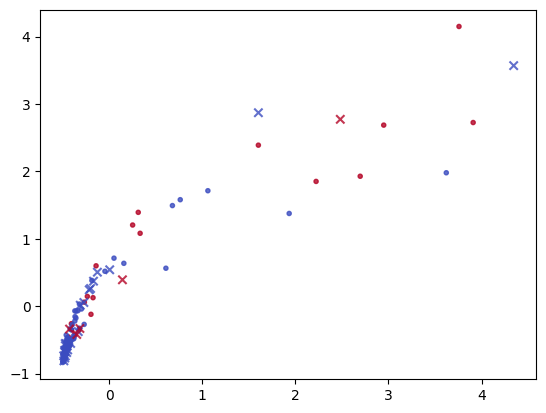

In [2]:
# Prepare development (train and validation) and test splits
from sklearn.model_selection import train_test_split

x = df[['area','perimeter']]
y = df[['melanoma']]

dev_x, test_x, dev_y, test_y = train_test_split(
        x, y, stratify=y, random_state=0)

train_x, val_x, train_y, val_y = train_test_split(
        dev_x, dev_y, stratify=dev_y, random_state=0)

print(f'train_x: {len(train_x)}\nval_x:   {len(val_x)}\ntest_x:  {len(test_x)}')

## TODOs for students

# For reducing computation, you may want to reduce the size of the selected data using train_size and test_size parameters.
# However, reducing the size of the dataset will lead to more variability of your results

# Think about exercises from last lecture, do we still want to do anything with the data? Do it here

# ANSWER: Using StandardScaler, fit only on train

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(train_x) # fit on the training data only to avoid data leakage

train_x = scaler.transform(train_x)
val_x = scaler.transform(val_x)         #same, already fitted, scaler
test_x = scaler.transform(test_x)       #same, already fitted, scaler

plt.scatter(train_x[:,0], train_x[:,1], c=train_y.values.ravel(), marker='.', cmap='coolwarm', alpha=0.8);
plt.scatter(val_x[:,0], val_x[:,1], c=val_y.values.ravel(), marker='x', cmap='coolwarm', alpha=0.8);

In [3]:
train_y.value_counts(), val_y.value_counts(), test_y.value_counts()

(melanoma
 0.0         67
 1.0         17
 Name: count, dtype: int64,
 melanoma
 0.0         23
 1.0          5
 Name: count, dtype: int64,
 melanoma
 0.0         30
 1.0          8
 Name: count, dtype: int64)

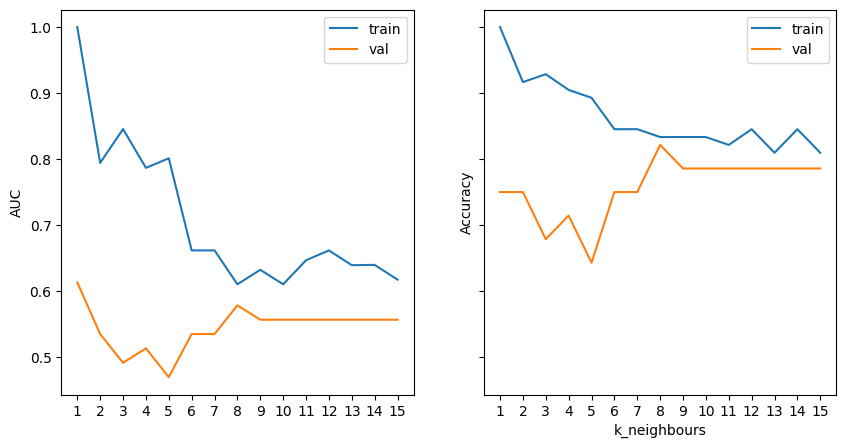

In [4]:
#Import classifier and metric
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


# Example of training a classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1_trained = knn1.fit(train_x, np.ravel(train_y))

# Example of prediction
val_pred_knn1 = knn1_trained.predict(val_x)
val_auc_knn1 = roc_auc_score(val_y, val_pred_knn1)

#print(f'k=1: {val_auc_knn1}')
train_auc_knn1 = roc_auc_score(train_y, knn1_trained.predict(train_x))
train_auc = [train_auc_knn1]
val_auc = [val_auc_knn1]

train_acc = [knn1_trained.score(train_x, train_y)]
val_acc = [knn1_trained.score(val_x, val_y)]

# TODOs for students:

# 1) Try out different parameters of K using a for loop

# 2) Make a plot of the training vs validation AUC in the same plot.
# You can also plot the accuracy metric in a different plot.
# Remember to add proper axes labels and legend to the plots (Fig 5.5 in tutorial)

# Q: Do you see the values you would expect?

n = 15

for k in np.arange(2, n+1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_trained = knn.fit(train_x, np.ravel(train_y))
    train_auc_knn = roc_auc_score(train_y, knn_trained.predict(train_x))

    val_pred_knn = knn_trained.predict(val_x)
    val_auc_knn = roc_auc_score(val_y, val_pred_knn)

    train_auc.append(train_auc_knn)
    val_auc.append(val_auc_knn)
    train_acc.append(knn_trained.score(train_x, train_y))
    val_acc.append(knn_trained.score(val_x, val_y))

    #print(f'k={k}: {val_auc_knn}')

_,ax = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
ax[0].plot(np.arange(1, n+1), train_auc, label='train')
ax[0].plot(np.arange(1, n+1), val_auc, label='val')

ax[1].plot(np.arange(1, n+1), train_acc, label='train')
ax[1].plot(np.arange(1, n+1), val_acc, label='val')

plt.xlabel('k_neighbours')
ax[0].set_ylabel('AUC')
ax[1].set_ylabel('Accuracy')
plt.xticks(np.arange(1, n+1))
ax[0].legend()
ax[1].legend();

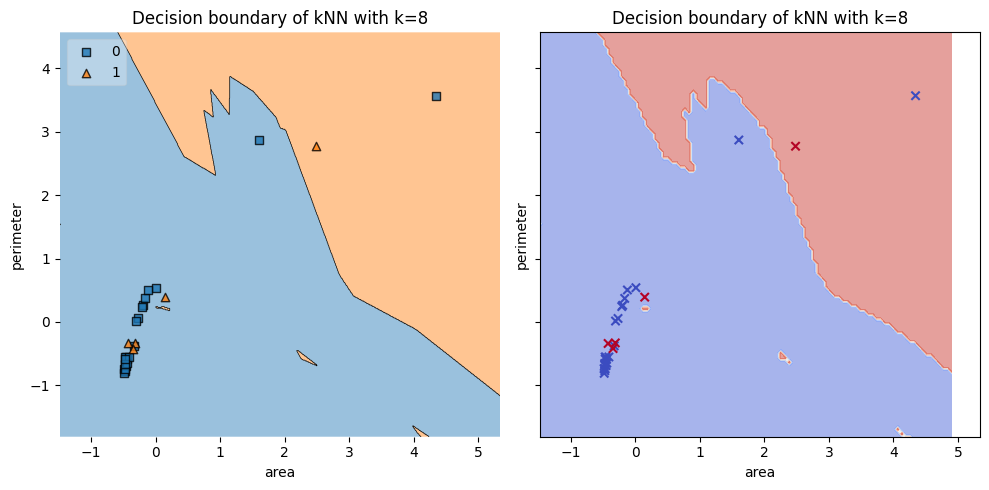

In [5]:
# Visualize the decision boundary

# TODO for students:

# Use the exercises from previous weeks to visualize the boundary of some appropriate / less appropriate choices for k (Fig 5.7 in tutorial)
n=8
knn = KNeighborsClassifier(n_neighbors=n)
knn_trained = knn.fit(train_x, np.ravel(train_y))

_, ax = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)

from mlxtend.plotting import plot_decision_regions

plot_decision_regions(val_x, np.ravel(val_y).astype('int'), clf=knn_trained, legend=2, ax=ax[0])
ax[0].set_xlabel('area')
ax[0].set_ylabel('perimeter')
ax[0].set_title(f'Decision boundary of kNN with k={n}')


## alternative method to plot decision boundary
from sklearn.inspection import DecisionBoundaryDisplay

display = DecisionBoundaryDisplay.from_estimator(
    knn, train_x, response_method="predict",
    xlabel='area', ylabel='perimeter',
    alpha=0.5, plot_method='contourf', 
    grid_resolution=100, cmap='coolwarm', ax=ax[1])

#ax[1].scatter(train_x[:, 0], train_x[:, 1], c=np.ravel(train_y), edgecolor="black", alpha=0.2, cmap='coolwarm')
ax[1].scatter(val_x[:, 0], val_x[:, 1], c=np.ravel(val_y), marker='x', cmap='coolwarm')
ax[1].set_title(f'Decision boundary of kNN with k={n}')

plt.tight_layout();

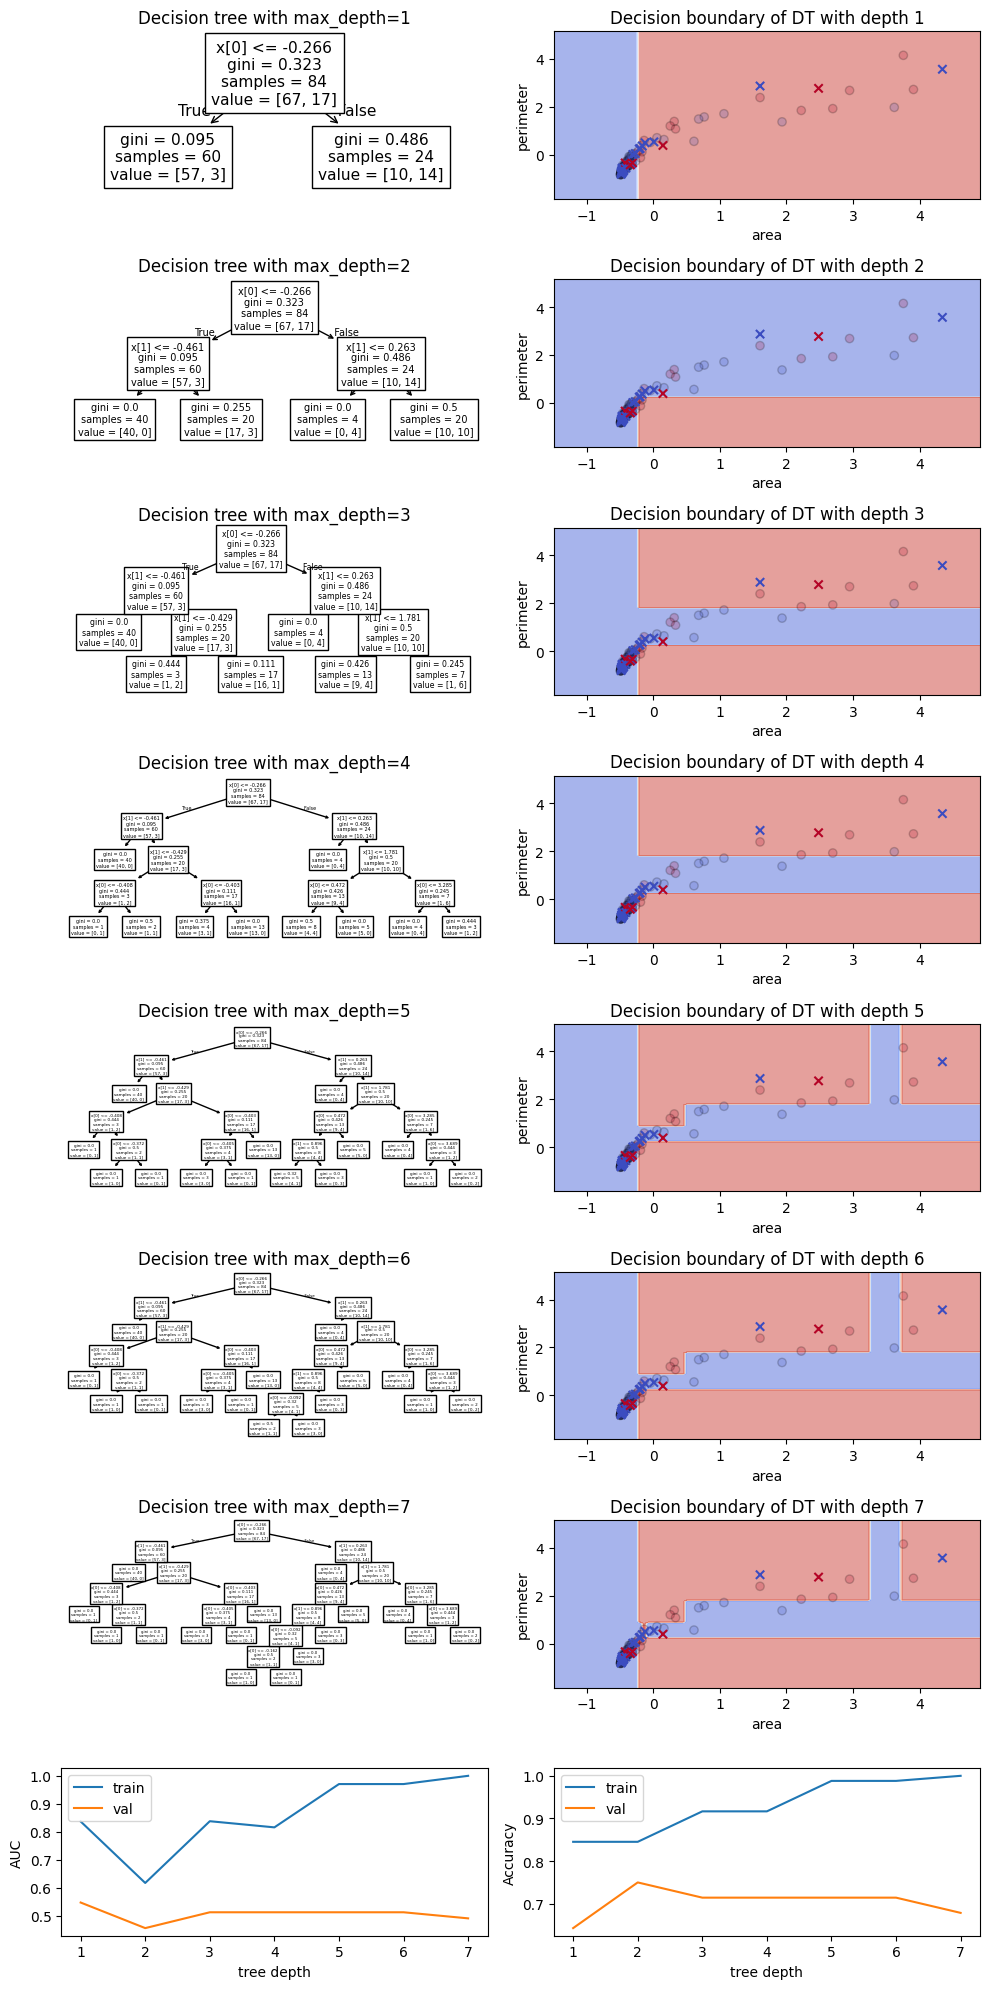

In [6]:
# Now let's try with a different classifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# TODOs for students:

# 1) Investigate the max_depth parameter of the classifier, and repeat the procedure above

# 2) Optionally, look at some other parameters of the classifier.
train_auc = []
val_auc = []

train_acc = []
val_acc = []

n = 7
_,ax = plt.subplots(8,2, figsize=(10,20))
#ax = ax.flatten()

for k in np.arange(1, n+1):
    dt = DecisionTreeClassifier(max_depth=k, random_state=0)
    dt_trained = dt.fit(train_x, np.ravel(train_y))
    train_auc_dt = roc_auc_score(train_y, dt_trained.predict(train_x))

    val_pred_dt = dt_trained.predict(val_x)
    val_auc_dt = roc_auc_score(val_y, val_pred_dt)

    train_auc.append(train_auc_dt)
    val_auc.append(val_auc_dt)
    train_acc.append(dt_trained.score(train_x, train_y))
    val_acc.append(dt_trained.score(val_x, val_y))

    plot_tree(dt_trained, ax=ax[k-1,0])
    ax[k-1,0].set_title(f'Decision tree with max_depth={k}')

    display = DecisionBoundaryDisplay.from_estimator(
        dt_trained, train_x, response_method="predict",
        xlabel='area', ylabel='perimeter',
        alpha=0.5, plot_method='contourf', 
        grid_resolution=100, cmap='coolwarm', ax=ax[k-1,1])

    ax[k-1,1].scatter(train_x[:, 0], train_x[:, 1], c=np.ravel(train_y), edgecolor="black", alpha=0.2, cmap='coolwarm')
    ax[k-1,1].scatter(val_x[:, 0], val_x[:, 1], c=np.ravel(val_y), marker='x', cmap='coolwarm')
    ax[k-1,1].set_title(f'Decision boundary of DT with depth {k}')

x_ = [x for x in range(len(train_auc))]

ax[n,0].plot(x_, train_auc, label='train')
ax[n,0].plot(x_, val_auc, label='val')

ax[n,1].plot(x_, train_acc, label='train')
ax[n,1].plot(x_, val_acc, label='val')

ax[n,0].set_xlabel('tree depth')
ax[n,1].set_xlabel('tree depth')

ax[n,0].set_ylabel('AUC')
ax[n,1].set_ylabel('Accuracy')

ax[n,0].set_xticks(x_, [x+1 for x in x_])
ax[n,1].set_xticks(x_, [x+1 for x in x_])

ax[n,0].legend()
ax[n,1].legend()

plt.tight_layout();

## Variance of performance depending on the split

Notice the random state parameter of the classifiers. Why do we need this?

You can try different choices for this parameter and investigate the effect on the results

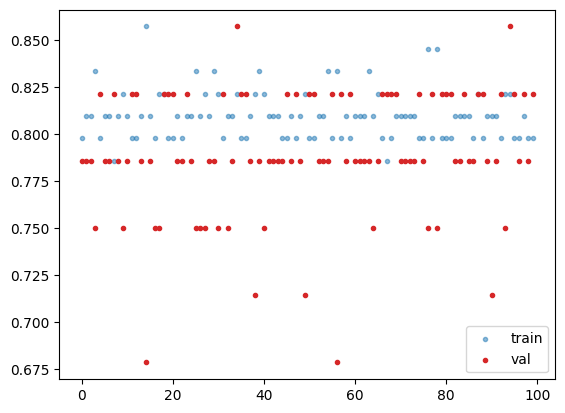

In [7]:
# TODO for students:

# Choose one of the experiments above, and create the performance vs parameter plot, for two different seeds
from random import randint, seed
seed(23)

seeds = [randint(0, 100) for _ in range(100)]

train_acc = []
val_acc = []


for i, s in enumerate(seeds):
    dev_x, test_x, dev_y, test_y = train_test_split(
        x, y, stratify=y, random_state=s)

    train_x, val_x, train_y, val_y = train_test_split(
        dev_x, dev_y, stratify=dev_y, random_state=s)
    
    scaler = StandardScaler()
    scaler.fit(train_x) # fit on the training data only to avoid data leakage

    train_x = scaler.transform(train_x)
    val_x = scaler.transform(val_x)         #same, already fitted, scaler
    test_x = scaler.transform(test_x)       #same, already fitted, scaler
    
    dt = KNeighborsClassifier(n_neighbors=8)
    dt_trained = dt.fit(train_x, np.ravel(train_y))
    train_acc.append(dt_trained.score(train_x, train_y))
    val_acc.append(dt_trained.score(val_x, val_y))

plt.scatter(np.arange(len(train_acc)), train_acc, marker='.', alpha=0.5, label='train', color='tab:blue');
#plt.hlines(np.mean(train_acc), 0, len(train_acc), color='tab:blue', label='train mean')
#plt.hlines(np.mean(val_acc), 0, len(val_acc), color='tab:red', label='val mean')
plt.scatter(np.arange(len(val_acc)), val_acc, label='val', marker='.', color='tab:red')
plt.legend();

1) What kind of strategies could you use to obtain more reliable performances?

ANSWER: More data, and/or use multiple splits and average


2) What does this tell you about the random_state, how is it different from for example a tunable k parameter?

ANSWER: Do not tune the random state

See [p-hacking notebook](https://github.com/YCL92/2025-FYP-Exercises/blob/main/08_classifiers_and_evaluation/optional_p-hacking_with_sols.ipynb) if you want to explore this more.

## Cross-validation

In this part we will use cross-validation on the development set to find good k / max_depth parameters

In [8]:
from sklearn.model_selection import KFold

# Create the folds
kfold = KFold(n_splits=5, random_state=None, shuffle=False)
kfold.get_n_splits(dev_x, dev_y)

# Check the contents of the folds
for i, (train_index, dev_index) in enumerate(kfold.split(dev_x)):

    print(f"Fold {i}:")

    print(f"  Train: index={train_index}")

    print(f"  Test:  index={dev_index}")

# TODO for students:

# Investigate other parameters of the KFold
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html


Fold 0:
  Train: index=[ 23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
  Test:  index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
  Test:  index=[23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
Fold 2:
  Train: index=[  0   1   2   3   4   5   6   7   

## Other types of KFold

In many medical imaging applications instead of KFold we need to use GroupKFold or other options in the model_selection library.

[GroupKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html#sklearn.model_selection.GroupKFold)

[StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold)

**Question:**  

Why might we need to use GroupKFold? Does it apply to this example data you are using? And does it apply to the PAD-UFES data? Which variable creates the groups?



## Effect of noisy features

Uninformative/noisy features will affect the generalization ability of your classifiers.

In this part we add uninformative (not correlated to class label) features and test (some) classifiers

train_x: (84, 22)
val_x:   (28, 22)
test_x:  (38, 22)


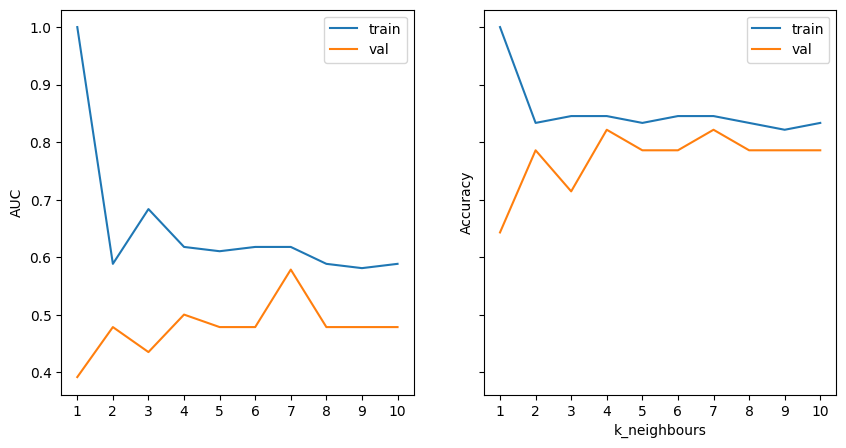

In [9]:
# Generate some noisy features
n_noisy_features = 20
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df.shape[0], n_noisy_features))

# Add the noisy data to the informative features
x_noisy = np.hstack((df[['area', 'perimeter']], noise))


# TODO for students
# Investigate the behavior of classifiers with regards to overfitting

dev_x, test_x, dev_y, test_y = train_test_split(
        x_noisy, y, stratify=y, random_state=0)

train_x, val_x, train_y, val_y = train_test_split(
        dev_x, dev_y, stratify=dev_y, random_state=0)

print(f'train_x: {train_x.shape}\nval_x:   {val_x.shape}\ntest_x:  {test_x.shape}')


scaler = StandardScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
val_x = scaler.transform(val_x)

train_auc = []
val_auc = []

train_acc = []
val_acc = []

n = 10

for k in np.arange(1, n+1):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn_trained = knn.fit(train_x, np.ravel(train_y))
    train_auc_knn = roc_auc_score(train_y, knn_trained.predict(train_x))

    val_pred_knn = knn_trained.predict(val_x)
    val_auc_knn = roc_auc_score(val_y, val_pred_knn)

    train_auc.append(train_auc_knn)
    val_auc.append(val_auc_knn)
    train_acc.append(knn_trained.score(train_x, train_y))
    val_acc.append(knn_trained.score(val_x, val_y))

_,ax = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
ax[0].plot(np.arange(1, n+1), train_auc, label='train')
ax[0].plot(np.arange(1, n+1), val_auc, label='val')

ax[1].plot(np.arange(1, n+1), train_acc, label='train')
ax[1].plot(np.arange(1, n+1), val_acc, label='val')

plt.xlabel('k_neighbours')
ax[0].set_ylabel('AUC')
ax[1].set_ylabel('Accuracy')
plt.xticks(np.arange(1, n+1))
ax[0].legend()
ax[1].legend();

## Combining everything and final evaluation

The examples above give you an idea of how you can investigate the quality of different classifiers and parameters. To keep track of the results (on the development set) of the options you try, you might want to make a "result dataset" where you track all the classifier versions and the corresponding results. MLFlow also allows doing this, but we do not cover it in the course (but perhaps the TAs can show you)

Then once you have evaluated all the options, you can select some of the better ones, retrain them, now you can use the entire development set for retraining.

Your choice of these options needs to be reproducible in your project, i.e., you should not try out some classifiers/parameters and then completely remove them from your project.

You can evaluate the re-trained classifiers on the so far held-out test set. Your performances (how good each classifier was) might not reflect your results on the validation set.

You are NOT allowed to edit the classifiers after this point


In [10]:
# TODO for students

# Keep track of different classifiers/parameters with an array

# Select some better ones (e.g. top 3)

# Re-train

# Evaluate on held-out set

In [11]:
# After this point you are not allowed to adjust the classifier, otherwise you are overfitting!